## 1. The NIST Special Publication 800-63B
<p>If you – 50 years ago – needed to come up with a secret password you were probably part of a secret espionage organization or (more likely) you were pretending to be a spy when playing as a kid. Today, many of us are forced to come up with new passwords <em>all the time</em> when signing into sites and apps. As a password <em>inventeur</em> it is your responsibility to come up with good, hard-to-crack passwords. But it is also in the interest of sites and apps to make sure that you use good passwords. The problem is that it's really hard to define what makes a good password. However, <em>the National Institute of Standards and Technology</em> (NIST) knows what the second best thing is: To make sure you're at least not using a <em>bad</em> password. </p>
<p>In this notebook, we will go through the rules in <a href="https://pages.nist.gov/800-63-3/sp800-63b.html">NIST Special Publication 800-63B</a> which details what checks a <em>verifier</em> (what the NIST calls a second party responsible for storing and verifying passwords) should perform to make sure users don't pick bad passwords. We will go through the passwords of users from a fictional company and use python to flag the users with bad passwords. But us being able to do this already means the fictional company is breaking one of the rules of 800-63B:</p>
<blockquote>
  <p>Verifiers SHALL store memorized secrets in a form that is resistant to offline attacks. Memorized secrets SHALL be salted and hashed using a suitable one-way key derivation function.</p>
</blockquote>
<p>That is, never save users' passwords in plaintext, always encrypt the passwords! Keeping this in mind for the next time we're building a password management system, let's load in the data.</p>
<p><em>Warning: The list of passwords and the fictional user database both contain <strong>real</strong> passwords leaked from <strong>real</strong> websites. These passwords have not been filtered in any way and include words that are explicit, derogatory and offensive.</em></p>

In [5]:
# Importing the pandas module
import pandas as pd

# Loading in datasets/users.csv 
users = pd.read_csv('users.csv')

# Printing out how many users we've got
print(len(users))

# Taking a look at the 12 first users
users.head(12)

982


,id,user_name,password
0,1,vance.jennings,joobheco
1,2,consuelo.eaton,0869347314
2,3,mitchel.perkins,fabypotter
3,4,odessa.vaughan,aharney88
4,5,araceli.wilder,acecdn3000
5,6,shawn.harrington,5278049
6,7,evelyn.gay,master
7,8,noreen.hale,murphy
8,9,gladys.ward,lwsves2
9,10,brant.zimmerman,1190KAREN5572497


## 2. Passwords should not be too short
<p>If we take a look at the first 12 users above we already see some bad passwords. But let's not get ahead of ourselves and start flagging passwords <em>manually</em>. What is the first thing we should check according to the NIST Special Publication 800-63B?</p>
<blockquote>
  <p>Verifiers SHALL require subscriber-chosen memorized secrets to be at least 8 characters in length.</p>
</blockquote>
<p>Ok, so the passwords of our users shouldn't be too short. Let's start by checking that!</p>

# What's the distribution of password lengths?

In [6]:
# Calculating the lengths of users' passwords
users['length'] = [len(i) for i in users['password'].values]

# Flagging the users with too short passwords
users['too_short'] = users['length'] < 8

# Counting and printing the number of users with too short passwords
print(len(users[users['too_short'] == True]))

# Taking a look at the 12 first rows
users.head(12)

376


,id,user_name,password,length,too_short
0,1,vance.jennings,joobheco,8,False
1,2,consuelo.eaton,0869347314,10,False
2,3,mitchel.perkins,fabypotter,10,False
3,4,odessa.vaughan,aharney88,9,False
4,5,araceli.wilder,acecdn3000,10,False
5,6,shawn.harrington,5278049,7,True
6,7,evelyn.gay,master,6,True
7,8,noreen.hale,murphy,6,True
8,9,gladys.ward,lwsves2,7,True
9,10,brant.zimmerman,1190KAREN5572497,16,False


# What's the distribution of password lengths?

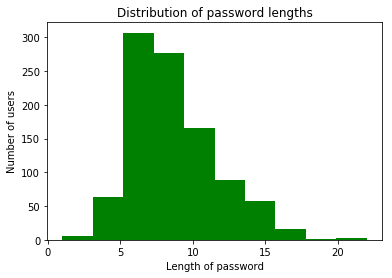

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(users['length'], color= 'g')
plt.title('Distribution of password lengths')
plt.xlabel('Length of password')
plt.ylabel('Number of users');

In [39]:
users['length'].mode()
users['length'].describe()

count    982.000000
mean       8.709776
std        2.848231
min        1.000000
25%        7.000000
50%        8.000000
75%       10.000000
max       22.000000
Name: length, dtype: float64

Looks like most users have a password length of 6, even though it is recommended to have at least 8 characters. Why do sites permit this?

## 3.  Common passwords people use
<p>Already this simple rule flagged a couple of offenders among the first 12 users. Next up in Special Publication 800-63B is the rule that</p>
<blockquote>
  <p>verifiers SHALL compare the prospective secrets against a list that contains values known to be commonly-used, expected, or compromised.</p>
  <ul>
  <li>Passwords obtained from previous breach corpuses.</li>
  <li>Dictionary words.</li>
  <li>Repetitive or sequential characters (e.g. ‘aaaaaa’, ‘1234abcd’).</li>
  <li>Context-specific words, such as the name of the service, the username, and derivatives thereof.</li>
  </ul>
</blockquote>
<p>We're going to check these in order and start with <em>Passwords obtained from previous breach corpuses</em>, that is, websites where hackers have leaked all the users' passwords. As many websites don't follow the NIST guidelines and encrypt passwords there now exist large lists of the most popular passwords. Let's start by loading in the 10,000 most common passwords which I've taken from <a href="https://github.com/danielmiessler/SecLists/tree/master/Passwords">here</a>.</p>

In [7]:
# Reading in the top 10000 passwords
common_passwords = pd.read_csv('10_million_password_list_top_10000.txt', header=None, squeeze=True)

# Taking a look at the top 20
common_passwords.head(20)

0        123456
1      password
2      12345678
3        qwerty
4     123456789
5         12345
6          1234
7        111111
8       1234567
9        dragon
10       123123
11     baseball
12       abc123
13     football
14       monkey
15      letmein
16       696969
17       shadow
18       master
19       666666
Name: 0, dtype: object

## 4.  Passwords should not be common passwords
<p>The list of passwords was ordered, with the most common passwords first, and so we shouldn't be surprised to see passwords like <code>123456</code> and <code>qwerty</code> above. As hackers also have access to this list of common passwords, it's important that none of our users use these passwords!</p>
<p>Let's flag all the passwords in our user database that are among the top 10,000 used passwords.</p>

In [8]:
# Flagging the users with passwords that are common passwords
users['common_password'] = users['password'].isin(common_passwords)

# Counting and printing the number of users using common passwords
print(len(users[users['common_password'] == True]))

# Taking a look at the 12 first rows
users.head(12)

129


,id,user_name,password,length,too_short,common_password
0,1,vance.jennings,joobheco,8,False,False
1,2,consuelo.eaton,0869347314,10,False,False
2,3,mitchel.perkins,fabypotter,10,False,False
3,4,odessa.vaughan,aharney88,9,False,False
4,5,araceli.wilder,acecdn3000,10,False,False
5,6,shawn.harrington,5278049,7,True,False
6,7,evelyn.gay,master,6,True,True
7,8,noreen.hale,murphy,6,True,True
8,9,gladys.ward,lwsves2,7,True,False
9,10,brant.zimmerman,1190KAREN5572497,16,False,False


## 5. Passwords should not be common words
<p>Ay ay ay! It turns out many of our users use common passwords, and of the first 12 users there are already two. However, as most common passwords also tend to be short, they were already flagged as being too short. What is the next thing we should check?</p>
<blockquote>
  <p>Verifiers SHALL compare the prospective secrets against a list that contains [...] dictionary words.</p>
</blockquote>
<p>This follows the same logic as before: It is easy for hackers to check users' passwords against common English words and therefore common English words make bad passwords. Let's check our users' passwords against the top 10,000 English words from <a href="https://github.com/first20hours/google-10000-english">Google's Trillion Word Corpus</a>.</p>

In [9]:
# Reading in a list of the 10000 most common words
words = pd.read_csv('google-10000-english.txt', header=None, squeeze=True)

# Flagging the users with passwords that are common words
users['common_word'] = users['password'].str.lower().isin(words)

# Counting and printing the number of users using common words as passwords
print(len(users[users['common_word']] == True))

# Taking a look at the 12 first rows
users.head(12)

137


,id,user_name,password,length,too_short,common_password,common_word
0,1,vance.jennings,joobheco,8,False,False,False
1,2,consuelo.eaton,0869347314,10,False,False,False
2,3,mitchel.perkins,fabypotter,10,False,False,False
3,4,odessa.vaughan,aharney88,9,False,False,False
4,5,araceli.wilder,acecdn3000,10,False,False,False
5,6,shawn.harrington,5278049,7,True,False,False
6,7,evelyn.gay,master,6,True,True,True
7,8,noreen.hale,murphy,6,True,True,True
8,9,gladys.ward,lwsves2,7,True,False,False
9,10,brant.zimmerman,1190KAREN5572497,16,False,False,False


## 6. Passwords should not be your name
<p>It turns out many of our passwords were common English words too! Next up on the NIST list:</p>
<blockquote>
  <p>Verifiers SHALL compare the prospective secrets against a list that contains [...] context-specific words, such as the name of the service, the username, and derivatives thereof.</p>
</blockquote>
<p>Ok, so there are many things we could check here. One thing to notice is that our users' usernames consist of their first names and last names separated by a dot. For now, let's just flag passwords that are the same as either a user's first or last name.</p>

In [10]:
# Extracting first and last names into their own columns
users['first_name'] = users['user_name'].str.extract('(^\w+)')
users['last_name'] = [i.split(".")[1] for i in users['user_name'].values]

# Flagging the users with passwords that matches their names
users['uses_name'] = (users['password'] == users['first_name']) | (users['password'] == users['last_name'])
# Counting and printing the number of users using names as passwords
print(len(users[users['uses_name'] == True]))

# Taking a look at the 12 first rows
users.head(12)

50


/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


,id,user_name,password,length,too_short,common_password,common_word,first_name,last_name,uses_name
0,1,vance.jennings,joobheco,8,False,False,False,vance,jennings,False
1,2,consuelo.eaton,0869347314,10,False,False,False,consuelo,eaton,False
2,3,mitchel.perkins,fabypotter,10,False,False,False,mitchel,perkins,False
3,4,odessa.vaughan,aharney88,9,False,False,False,odessa,vaughan,False
4,5,araceli.wilder,acecdn3000,10,False,False,False,araceli,wilder,False
5,6,shawn.harrington,5278049,7,True,False,False,shawn,harrington,False
6,7,evelyn.gay,master,6,True,True,True,evelyn,gay,False
7,8,noreen.hale,murphy,6,True,True,True,noreen,hale,False
8,9,gladys.ward,lwsves2,7,True,False,False,gladys,ward,False
9,10,brant.zimmerman,1190KAREN5572497,16,False,False,False,brant,zimmerman,False


In [11]:
users.head()

,id,user_name,password,length,too_short,common_password,common_word,first_name,last_name,uses_name
0,1,vance.jennings,joobheco,8,False,False,False,vance,jennings,False
1,2,consuelo.eaton,0869347314,10,False,False,False,consuelo,eaton,False
2,3,mitchel.perkins,fabypotter,10,False,False,False,mitchel,perkins,False
3,4,odessa.vaughan,aharney88,9,False,False,False,odessa,vaughan,False
4,5,araceli.wilder,acecdn3000,10,False,False,False,araceli,wilder,False


## 7. Passwords should not be repetitive
<p>Milford Hubbard (user number 12 above), what where you thinking!? Ok, so the last thing we are going to check is a bit tricky:</p>
<blockquote>
  <p>verifiers SHALL compare the prospective secrets [so that they don't contain] repetitive or sequential characters (e.g. ‘aaaaaa’, ‘1234abcd’).</p>
</blockquote>
<p>This is tricky to check because what is <em>repetitive</em> is hard to define. Is <code>11111</code> repetitive? Yes! Is <code>12345</code> repetitive? Well, kind of. Is <code>13579</code> repetitive? Maybe not..? To check for <em>repetitiveness</em> can be arbitrarily complex, but here we're only going to do something simple. We're going to flag all passwords that contain 4 or more repeated characters.</p>

In [12]:
### Flagging the users with passwords with >= 4 repeats
users['too_many_repeats'] = users['password'].str.contains(r'(.)\1\1\1')

# Taking a look at the users with too many repeats
users[users['too_many_repeats'] == True]

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,id,user_name,password,length,too_short,common_password,common_word,first_name,last_name,uses_name,too_many_repeats
146,147,patti.dixon,555555,6,True,True,False,patti,dixon,False,True
572,573,cornelia.bradley,555555,6,True,True,False,cornelia,bradley,False,True
644,645,essie.lopez,11111,5,True,True,False,essie,lopez,False,True
798,799,charley.key,888888,6,True,True,False,charley,key,False,True
807,808,thurman.osborne,rinnnng0,8,False,False,False,thurman,osborne,False,True
941,942,mitch.ferguson,aaaaaa,6,True,True,False,mitch,ferguson,False,True


## 8. All together now!
<p>Now we have implemented all the basic tests for bad passwords suggested by NIST Special Publication 800-63B! What's left is just to flag all bad passwords and maybe to send these users an e-mail that strongly suggests they change their password.</p>

In [13]:
users.head(10)

,id,user_name,password,length,too_short,common_password,common_word,first_name,last_name,uses_name,too_many_repeats
0,1,vance.jennings,joobheco,8,False,False,False,vance,jennings,False,False
1,2,consuelo.eaton,0869347314,10,False,False,False,consuelo,eaton,False,False
2,3,mitchel.perkins,fabypotter,10,False,False,False,mitchel,perkins,False,False
3,4,odessa.vaughan,aharney88,9,False,False,False,odessa,vaughan,False,False
4,5,araceli.wilder,acecdn3000,10,False,False,False,araceli,wilder,False,False
5,6,shawn.harrington,5278049,7,True,False,False,shawn,harrington,False,False
6,7,evelyn.gay,master,6,True,True,True,evelyn,gay,False,False
7,8,noreen.hale,murphy,6,True,True,True,noreen,hale,False,False
8,9,gladys.ward,lwsves2,7,True,False,False,gladys,ward,False,False
9,10,brant.zimmerman,1190KAREN5572497,16,False,False,False,brant,zimmerman,False,False


In [14]:
# Flagging all passwords that are bad
users['bad_password'] = ((users['too_short'] == True) |
                        (users['common_password'] == True) |
                        (users['common_word'] ==True) |
                        (users['uses_name'] == True) |
                        (users['too_many_repeats'] == True))

# Counting and printing the number of bad passwords
print(len(users[users['bad_password'] == True]))

# Looking at the first 25 bad passwords
users[users['bad_password'] == True].head(25)

424


,id,user_name,password,length,too_short,common_password,common_word,first_name,last_name,uses_name,too_many_repeats,bad_password
5,6,shawn.harrington,5278049,7,True,False,False,shawn,harrington,False,False,True
6,7,evelyn.gay,master,6,True,True,True,evelyn,gay,False,False,True
7,8,noreen.hale,murphy,6,True,True,True,noreen,hale,False,False,True
8,9,gladys.ward,lwsves2,7,True,False,False,gladys,ward,False,False,True
11,12,milford.hubbard,hubbard,7,True,False,False,milford,hubbard,True,False,True
13,14,jamie.cochran,310356,6,True,False,False,jamie,cochran,False,False,True
15,16,lorrie.gay,oZ4k0QE,7,True,False,False,lorrie,gay,False,False,True
16,17,domingo.dyer,chelsea,7,True,True,True,domingo,dyer,False,False,True
17,18,martin.pacheco,zvc1939,7,True,False,False,martin,pacheco,False,False,True
18,19,shelby.massey,nickgd,6,True,False,False,shelby,massey,False,False,True


In [46]:
prop = round((len(users[users['bad_password'] == True]))/len(users), 2)
print("The proportion of users with bad passwords is", prop)

The proportion of users with bad passwords is 0.43


That's close to half the people on the password list with a bad password! 

## 9. Otherwise, the password should be up to the user
<p>In this notebook, we've implemented the password checks recommended by the NIST Special Publication 800-63B. It's certainly possible to better implement these checks, for example, by using a longer list of common passwords. Also note that the NIST checks in no way guarantee that a chosen password is good, just that it's not obviously bad.</p>
<p>Apart from the checks we've implemented above the NIST is also clear with what password rules should <em>not</em> be imposed:</p>
<blockquote>
  <p>Verifiers SHOULD NOT impose other composition rules (e.g., requiring mixtures of different character types or prohibiting consecutively repeated characters) for memorized secrets. Verifiers SHOULD NOT require memorized secrets to be changed arbitrarily (e.g., periodically).</p>
</blockquote>
<p>So the next time a website or app tells you to "include both a number, symbol and an upper and lower case character in your password" you should send them a copy of <a href="https://pages.nist.gov/800-63-3/sp800-63b.html">NIST Special Publication 800-63B</a>.</p>

In [15]:
# Enter a password that passes the NIST requirements

new_password = "J1ngleb3lls"